# Dynamic Programming Approach for Single asset

In [151]:
import numpy as np
from scipy.stats import multivariate_normal
def generate_normal_distribution(n):

    L = np.random.rand(n, n)
    cov_matrix = np.dot(L, L.T)

    mean = np.random.randn(n)
    print(mean)
    
    return [mean,cov_matrix]

#generate_normal_distribution(5)


R0 = np.random.randn(1)
print(R0)
def get_riskfree_price(t):
    return R0*np.exp(rf*t)

n = 1
regimes = []
N = 2
T= 50
rf = 0.0154/50
gamma = -1
tpm = np.array([[0.981,0.019],[0.047,0.953]])
#transaction_rate = 0.1
# for i in range(N):
#     regimes.append(generate_normal_distribution(n))

regimes = [[[0.00312],[[0.00022]]],[[-0.00175],[[0.00116]]]]

def generate_scenario(prob,t):
    # curren
    # returns_for_regimes = []
    # for i in range(N):
    #     sample = np.random.multivariate_normal(mean = regimes[i][0], cov= regimes[i][1])
    #     returns_for_regimes.append(sample)

    # returns_for_regimes = np.array(returns_for_regimes)

    # sample = []
    # for i in range(n):
    #     value = 0
    #     for j in range(N):
    #         value+= prob[j]*returns_for_regimes[j][i]
    #     sample.append(value)
    # sample.append(get_riskfree_price(t)[0])
    current_regime = np.random.choice(N,p = prob)
    #print(current_regime)
    sample = list(np.random.multivariate_normal(mean = regimes[current_regime][0], cov= regimes[current_regime][1]))
    #sample.append(get_riskfree_price(t)[0])
    sample.append(rf)
    return np.array(sample)

def generate_monte_carlo_sample():
    sample = []
    curr_prob = np.random.rand(N)
    curr_prob/=np.sum(curr_prob)
    curr_regime = np.random.choice(range(N), p = curr_prob)
    #print(regimes[curr_regime][1])
    returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
    returns.append(rf)
    sample.append([curr_regime,returns])
    for i in range(T-1):
        curr_prob = tpm @ curr_prob
        curr_prob/=np.sum(curr_prob)
        curr_regime = np.random.choice(range(N), p = curr_prob)
        returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
        returns.append(rf)
        sample.append([curr_regime,returns])
    
    return sample


generate_monte_carlo_sample()




#generate_scenario([0.1,0.1,0.3,0.2,0.3],1)

[-0.10901082]


[[1, [-0.02637119549933424, 0.000308]],
 [0, [-0.003925489439034004, 0.000308]],
 [0, [0.001433060220007208, 0.000308]],
 [0, [-0.0003021229777282262, 0.000308]],
 [1, [0.06195451295958909, 0.000308]],
 [0, [0.01958357405144355, 0.000308]],
 [1, [-0.030584493046751444, 0.000308]],
 [0, [-0.0035973842553287242, 0.000308]],
 [1, [-0.024172612483892093, 0.000308]],
 [0, [-0.00612667760598358, 0.000308]],
 [1, [-0.01340361822068544, 0.000308]],
 [0, [0.005699398015680224, 0.000308]],
 [0, [0.02885188680123323, 0.000308]],
 [1, [0.013808115115656758, 0.000308]],
 [1, [0.02020936999199747, 0.000308]],
 [1, [-0.039285383742190254, 0.000308]],
 [0, [0.010816333403151503, 0.000308]],
 [1, [-0.020625283799474405, 0.000308]],
 [0, [-0.013292467264263282, 0.000308]],
 [0, [-0.008014220641217885, 0.000308]],
 [1, [-0.0396577298359725, 0.000308]],
 [1, [0.025128735245069367, 0.000308]],
 [0, [0.0013258749627051165, 0.000308]],
 [1, [0.011875506519307473, 0.000308]],
 [1, [0.028412642804753325, 0.000

In [152]:
print(regimes[1][:])

[[-0.00175], [[0.00116]]]


## Probabilty set initialization over different regimes

In [153]:
from itertools import product
from scipy.optimize import minimize
discrete_prob = 10
prob_set = []
for i in range(discrete_prob+1):
    prob_set.append(1/(discrete_prob)*i)

combinations = product(prob_set, repeat=N)
possible_probabities = [vector for vector in combinations if sum(vector) == 1]
reverse_index = {}
for _,p in enumerate(possible_probabities):
    reverse_index[p]= _

possible_probabities = [np.array(x) for x in possible_probabities]


In [154]:
delta_pi = 0.1
pi_set = []
curr_pi = -1
while curr_pi<=1+1e-5:
    pi_set.append(curr_pi)
    curr_pi+=delta_pi

pi_combinations = product(pi_set,repeat=n)
possible_pi = [np.append(np.array(vector),1-np.sum(vector)) for vector in pi_combinations]


In [155]:
print(possible_pi[-1])

[1.00000000e+00 2.22044605e-16]


In [140]:
def closest_probability_distn(p_in):
    lowest_norm = float('inf')  # Set to positive infinity initially
    ind = 0
    #p_in = p_in.detach().numpy()
    # Iterate through the set and calculate the norm for each element
    for _,array in enumerate(possible_probabities):
        norm = np.linalg.norm(p_in - array)  # Calculate the Euclidean norm
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = _

    return ind,closest_array

def updateBelief(r,p):
    #print(r,p)
    p_new = []
    #print(r)
    r = r[:-1]
    density = np.zeros(N);
    for i in range(N):
        mvn = multivariate_normal(mean=regimes[i][0], cov = regimes[i][1])
        density[i]= mvn.pdf(r)

    p_new = np.zeros(N)
    for i in range(N):
        for j in range(N):
            p_new[i]+= density[j]*tpm[j][i]*p[j]

    p_new/=np.sum(p_new)
    closest_p_ind,_ = closest_probability_distn(p_new)
    return p_new,closest_p_ind

def newWealth(r, pi):
    W_new = 0
    for i in range(n+1):
        W_new+= pi[i]*(1+r[i])
    return W_new

In [141]:
V = {}
for _ in range(len(possible_probabities)):
    V[(_,T)] = (1**gamma)/gamma

t = T-1
M = 200
pi_l = -1.0
pi_u = 1.0

   
optimal_pi_star = {}

# scenarios = []_star = {}
for iter in range(1):
    # scenarios = []
    # for j in range(M):
    #     sample = generate_monte_carlo_sample()
    #     scenarios.append(sample)
    # print(scenarios)
    t = T-1
    while (t>=0):
        # returns_at_this_time = [scenarios[i][t][1] for i in range(M)]
        # print(returns_at_this_time)
        for _ in range(len(possible_probabities)):
            returns_at_this_time = []
            for j in range(M):
                sample = generate_scenario(possible_probabities[_],t)
                returns_at_this_time.append(sample)
            def objective_function(pi):
                return np.average([(newWealth(returns_at_this_time[i],pi)**gamma)*V[(updateBelief(returns_at_this_time[i],possible_probabities[_])[1],t+1)] for i in range(M)])

            constraints = ([{'type': 'eq', 'fun': lambda pi: np.sum(pi) - 1}])  # Example constraint: pi sums to 1

            #Initial guess for pi (dimension n)
            # initial_pi_guess = np.ones(n+1) 
            # initial_pi_guess/=np.sum(initial_pi_guess)# Starting with equal weights

            # #Minimize the negative of the objective function to maximize
            # pi_star = minimize(lambda x: (-1)*objective_function(x),  initial_pi_guess,
            #                    constraints=constraints,
            #                     bounds = [(pi_l,pi_u) for i in range(n)] + [(None,None)]
            #                     )

            pi_star = max(possible_pi,key = objective_function)
            # print(pi_star.message)
            # pi_star = pi_star.x
            # for i in range(n+1):
            #     pi_star[i] = max(pi_l,min(pi_u,pi_star[i]))
            V[(_,t)] = np.average([(newWealth(returns_at_this_time[i],pi_star)**gamma)*V[(updateBelief(returns_at_this_time[i],possible_probabities[_])[1],t+1)] for i in range(M)])
            optimal_pi_star[(_,t)] = pi_star
            print(iter,t,possible_probabities[_],pi_star)

        t= t-1
        print("\n")



0 4 [0. 1.] [-1  2]
0 4 [0.1 0.9] [-0.7  1.7]
0 4 [0.2 0.8] [-1  2]
0 4 [0.3 0.7] [0.7 0.3]
0 4 [0.4 0.6] [-0.2  1.2]
0 4 [0.5 0.5] [-0.1  1.1]
0 4 [0.6 0.4] [-1.38777878e-16  1.00000000e+00]
0 4 [0.7 0.3] [1.00000000e+00 2.22044605e-16]
0 4 [0.8 0.2] [1.00000000e+00 2.22044605e-16]
0 4 [0.9 0.1] [1.00000000e+00 2.22044605e-16]
0 4 [1. 0.] [1.00000000e+00 2.22044605e-16]


0 3 [0. 1.] [-0.5  1.5]
0 3 [0.1 0.9] [-0.9  1.9]
0 3 [0.2 0.8] [-0.5  1.5]
0 3 [0.3 0.7] [0.4 0.6]
0 3 [0.4 0.6] [-0.2  1.2]
0 3 [0.5 0.5] [-1  2]
0 3 [0.6 0.4] [1.00000000e+00 2.22044605e-16]
0 3 [0.7 0.3] [0.8 0.2]
0 3 [0.8 0.2] [1.00000000e+00 2.22044605e-16]
0 3 [0.9 0.1] [1.00000000e+00 2.22044605e-16]
0 3 [1. 0.] [1.00000000e+00 2.22044605e-16]


0 2 [0. 1.] [-0.5  1.5]
0 2 [0.1 0.9] [0.4 0.6]
0 2 [0.2 0.8] [-0.9  1.9]
0 2 [0.3 0.7] [-1  2]
0 2 [0.4 0.6] [-0.4  1.4]
0 2 [0.5 0.5] [-0.5  1.5]
0 2 [0.6 0.4] [-0.7  1.7]
0 2 [0.7 0.3] [1.00000000e+00 2.22044605e-16]
0 2 [0.8 0.2] [1.00000000e+00 2.22044605e-16]
0 

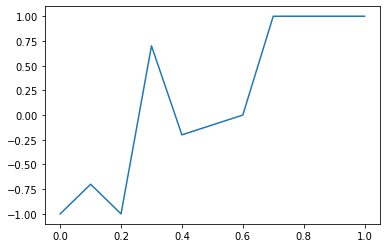

[array([0.3, 0.7]), array([-1,  2]), array([-1,  2]), array([-0.5,  1.5]), array([-0.2,  1.2])]


In [144]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,4][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.show()

print([optimal_pi_star[_,0] for _ in range(5)])

In [ ]:
for _ in range(len(possible_probabities)):
    print(possible_probabities[_])
    print(V[(_,0)])

[0. 1.]
-0.9948425281848563
[0.02 0.98]
-0.9954187341391277
[0.04 0.96]
-0.9936693202103825
[0.06 0.94]
-0.993258559195663
[0.08 0.92]
-0.9956728746280783
[0.1 0.9]
-0.9949216142604204
[0.12 0.88]
-0.9956795704411443
[0.14 0.86]
-0.9953472068804257
[0.16 0.84]
-0.9952948148439712
[0.18 0.82]
-0.9960670864163788
[0.2 0.8]
-0.9951257883536586
[0.22 0.78]
-0.9957399363347562
[0.24 0.76]
-0.994940870256214
[0.26 0.74]
-0.9951479844356311
[0.28 0.72]
-0.995584034805725
[0.3 0.7]
-0.9955870860715633
[0.32 0.68]
-0.9959215933066633
[0.34 0.66]
-0.9958207307194427
[0.36 0.64]
-0.9953794189633677
[0.38 0.62]
-0.9959068760439989
[0.4 0.6]
-0.9956560043730692
[0.42 0.58]
-0.9951605747336234
[0.44 0.56]
-0.994749418915084
[0.46 0.54]
-0.9950926274636861
[0.48 0.52]
-0.9950210010373791
[0.5 0.5]
-0.9940251364600347
[0.52 0.48]
-0.9943786368043029
[0.54 0.46]
-0.995131073674532
[0.56 0.44]
-0.9939270025692986
[0.58 0.42]
-0.9937538348009185
[0.6 0.4]
-0.9934857495776473
[0.62 0.38]
-0.99318550642611

# Neural Network using Dynamic Program solution as a startpoint

In [145]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers


In [146]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# transaction_rate = 0.005

# def newWealth_withTC(W,r,pi_pre,pi_new):
#     # W_new = torch.scalar_tensor(0,requires_grad=True)
#     # #W_new = 0
#     # #W = torch.scalar_tensor(W,requires_grad=True)
#     # r = torch.tensor(r,requires_grad=True)
#     # for i in range(n+1):
#     #     W_new += W*pi_pre[i]*(1+r[i])
#     # W_new = W_new - W_new*transaction_rate*torch.norm(pi_new-pi_pre,p = 1)
#     # return torch.tensor(W_new,requires_grad=True)
#     W = torch.tensor(W, requires_grad=True)
#     r = torch.tensor(r, requires_grad=True)
#     pi_pre = torch.tensor(pi_pre, requires_grad=True)
#     pi_new = torch.tensor(pi_new, requires_grad=True)

#     n = len(r) - 1
#     W_new = torch.scalar_tensor(0.0, requires_grad=True)

#     # Accumulate values in a new tensor without in-place operations
#     for i in range(n + 1):
#         W_new = W_new + W * pi_pre[i] * (1 + r[i])

#     tc = transaction_rate * torch.norm(pi_new - pi_pre, p=1)

#     # Update W_new with the transaction cost
#     W_new = W_new - W_new * tc

#     return W_new


# class CustomLoss(nn.Module):
#     def __init__(self, crra_coefficient):
#         super(CustomLoss, self).__init__()
#         self.crra_coefficient = crra_coefficient

#     def forward(self, initial_wealth, initial_portfolio, upper_b, lower_b,returns,input_data):
#         # Calculate the CRRA utility loss
#         input_size = upper_b.shape[0]
#         total_loss = 0
#         #print(lower_b.shape,upper_b.shape)
#         for _ in range(input_size):
#             wealth = [initial_wealth]
#             portfolio = [initial_portfolio]
#             pi_star_arrays = []
#             #print(portfolio)
#             #constraint_loss = 0
#             for i in range(T):
#                 w = wealth[-1]
#                 pi = portfolio[-1]
#                 pi_new = pi.clone().detach()
#                 pi_new = pi_new[:-1]

#                 closest_p_ind,__ = closest_probability_distn(input_data[_][i])
#                 pi_star = torch.tensor(optimal_pi_star[(closest_p_ind,i)],requires_grad=True)
#                 pi_star_arrays.append(pi_star)
#                 pi_star = pi_star[:-1]
#                 #print("Pi star: ",pi_star)
#                 #print(lb,ub)
#                 # print("Pi_star :",pi_star)
#                 u_b = upper_b[_][i]
#                 l_b = lower_b[_][i]

#                 #print("Boundaries: ",l_b,u_b)
#                 #constraint_loss+= torch.sum(torch.relu(l_b - u_b))*1000
#                 #print(constraint_loss)
#                 # print("Pi: ",pi_new)
#                 # print("Upper_delta: ",u_b)
#                 # print("Lower delta: ",l_b)
#                 # for j in range(n):
#                 #     pi_new[j] = max(max(-1.0,l_b[j]), min(min(u_b[j],1), pi_new[j]))
#                 u_b = torch.min(torch.ones(n),torch.add(pi_star,u_b))
#                 l_b = torch.max(-torch.ones(n),torch.add(pi_star,-l_b))
#                 pi_new = torch.max(l_b,torch.min(u_b,pi_new))
#                 # print("Upper boundary: ",u_b)
#                 # print("Lower_boundary: ",l_b)
#                 # print("Pi: ",pi_new)
#                 risk_free_allocation = torch.tensor([1-torch.sum(pi_new)],requires_grad=True)
#                 #print(risk_free_allocation)
#                 #print(risk_free_allocation)
#                 pi_new = torch.stack((pi_new,risk_free_allocation)).reshape(n+1)
#                 #print(pi_new)
#                 portfolio.append(torch.tensor(pi_new,requires_grad=True))
#                 #print(portfolio)
#                 new_wealth = newWealth_withTC(W=w,r = returns[_][i], pi_pre= pi,pi_new= pi_new)
#                 #print(new_wealth)
#                 wealth.append(new_wealth)

#             #print(wealth)
#             loss = -((wealth[-1]) ** self.crra_coefficient) / self.crra_coefficient 

#             total_loss+= loss
#             # print("Portfolio: ",portfolio)
#             # print("Wealth: ",wealth)
#             # print("Optimal_portfolios: ",pi_star_arrays)
        
#         return total_loss/input_size

# # Define your RNN cell with two neural networks
# class CustomRNNCell(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(CustomRNNCell, self).__init__()
#         self.input_size = input_size
#         #self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.rnn = nn.RNN(input_size, hidden_size = output_size, num_layers = 1, batch_first=True)
#         #self.fc1 = nn.Linear(input_size, output_size)
#           #Network for "no-trade"
#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(input_size,80,bias = True),
#         #     nn.Sigmoid(),
#         #     nn.Linear(80,40),
#         #     nn.Sigmoid(),
#         #     nn.Linear(40,20),
#         #     nn.Sigmoid(),
#         #     nn.Linear(20,output_size),
#         #     nn.Sigmoid()
#         # )
#         # # # self.fc2 = nn.Linear(input_size, output_size)  # Network for "x-zone"
#         # # self.fc2 = nn.Sequential(
#         # #     nn.Linear(input_size,80),
#         # #     nn.Tanh(),
#         # #     nn.Linear(80,40),
#         # #     nn.ReLU(),
#         # #     nn.Linear(40,20),
#         # #     nn.ReLU(),
#         # #     nn.Linear(20,output_size),
#         # #     nn.Tanh()
#         # # )
#         # self.fc2 = nn.Sequential(
#         #     nn.Linear(input_size,80,bias = False),
#         #     nn.Sigmoid(),
#         #     nn.Linear(80,40,bias = False),
#         #     nn.Sigmoid(),
#         #     nn.Linear(40,20,bias = False),
#         #     nn.Sigmoid(),
#         #     nn.Linear(20,output_size,bias = False),
#         #     nn.Sigmoid()
#         # )

#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(input_size, 80, bias=True),
#         #     nn.Tanh(),  # ReLU activation for better sensitivity
#         #     #nn.BatchNorm1d(80),  # Batch normalization
#         #     nn.Linear(80, 40, bias=True),
#         #     nn.Tanh(),  # ReLU activation
#         #     #nn.BatchNorm1d(40),  # Batch normalization
#         #     nn.Linear(40, 20, bias=True),
#         #     nn.Tanh(),  # ReLU activation
#         #     #nn.BatchNorm1d(20),  # Batch normalization
#         #     nn.Linear(20, output_size),
#         #     nn.Sigmoid()
#         # )   

#         # self.fc2 = nn.Sequential(
#         #     nn.Linear(input_size, 80, bias=True),
#         #     nn.Tanh(),  # Tanh activation
#         #     #nn.BatchNorm1d(80),  # Batch normalization
#         #     nn.Linear(80, 40, bias=True),
#         #     nn.Tanh(),  # Tanh activation
#         #     #nn.BatchNorm1d(40),  # Batch normalization
#         #     nn.Linear(40, 20, bias=True),
#         #     nn.Tanh(),  # Tanh activation
#         #     #nn.BatchNorm1d(20),  # Batch normalization
#         #     nn.Linear(20, output_size, bias=True),
#         #     nn.Sigmoid()
#         # )   

#         #self.observed_boundaries = []

#     def forward(self, x):
#         input_to_nn= x.reshape(-1,N)
#         #print(x.shape)
#         # out_l = self.fc1(x*1000)
#         # out_u = self.fc2(x*1000)
#         # print(out_l)
#         # print(out_u)
#         #print(out.shape)
#         # out_no_trade = self.fc1(out)
#         # out_x_zone = self.fc2(out)
#         #print(out_u.shape)
#         # lower_b = out_l.reshape(-1,T,n)
#         # upper_b = out_u.reshape(-1,T,n)
#         #print(x.shape)
#         # lower_b = torch.tanh(self.fc1(x))
#         # upper_b = torch.tanh(self.fc2(x))
#         #upper_b = torch.maximum(lower_b,upper_b)
#         out,_ = self.rnn(x)
#         out = torch.sigmoid(x)
#         out_l = out[:,:,:n]
#         out_u = out[:,:,n:]
#         return torch.tensor(out_l,requires_grad=True),torch.tensor(out_u,requires_grad=True)

# # Example usage of the custom loss function and RNN cell
# input_size = N  # Replace with the appropriate input size
# #hidden_size = 150  # Replace with the appropriate hidden size
# output_size = 2*n # 2 output units, "no-trade" and "x-zone" decisions
# crra_coefficient = 1  # CRRA coefficient, adjust as needed

# rnn_cell = CustomRNNCell(input_size, output_size)
# custom_loss = CustomLoss(crra_coefficient)

# # Generate some example data
# #input_data = torch.randn(T, input_size)  # (batch_size, sequence_length, input_size)
# #target_data = torch.randn(T, output_size)  # (batch_size, sequence_length, output_size)
# #regime_probs = torch.rand(T,2)  # Probability vector over regimes

# n_samples = 1000
# input_data = []
# return_samples= []
# cnt0 = 0
# plot_x = []
# for i in range(n_samples):
#     sample = generate_monte_carlo_sample()
#     if(sample[0][0]==0):
#         cnt0+=1
#     returns_for_this_sample = []
#     for time in range(T):
#         returns_for_this_sample.append(sample[time][1])
#     return_samples.append(returns_for_this_sample)
#     #return_samples.append()
#     initial_p = np.random.rand(N)
#     plot_x.append(initial_p[0])
#     initial_p/=np.sum(initial_p)
#     input_to_rnn = [initial_p]
#     for time in range(T-1):
#         p = input_to_rnn[-1]
#         p_new = updateBelief_for_RNN(sample[time][1],p)
#         #p_new = closest_probability_distn(p_new)[1]
#         plot_x.append(p_new[0])
#         input_to_rnn.append(p_new)
#     input_data.append(input_to_rnn)

# print(cnt0)
# print(len(plot_x))
# import matplotlib.pyplot as plt
# plt.hist(plot_x,bins = 100)
# plt.show()

# print("Input data: ",input_data[0])
# print("Return_Samples: ",return_samples[0])
# input_data = torch.tensor(input_data,dtype= torch.float32,requires_grad=True)
# #return_samples = torch.tensor(return_samples,dtype = torch.float32)

# optimizer = optim.Adam(rnn_cell.parameters(), lr=0.0001)
# #print(reverse_index)
# # Forward pass and compute lossnp.ones(n+1)/(n+1)
# for iter in range(10):
#     lb,ub = rnn_cell(input_data)
#     #print(lb.shape)
#     #print(lb,ub)
#     initial_wealth = torch.scalar_tensor(1000,requires_grad=True)
#     initial_portfolio = torch.rand(n+1,requires_grad=True)
#     initial_portfolio = initial_portfolio/torch.sum(initial_portfolio)
#     loss = custom_loss(initial_wealth= initial_wealth,initial_portfolio = initial_portfolio,upper_b = ub,lower_b = lb,returns = np.array(return_samples),input_data = input_data)

#     print("Loss: ",loss)
#     # You can then use these losses to perform backpropagation and optimize your RNN cell using an optimizer like Adam.
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

    




In [147]:
# import matplotlib.pyplot as plt
# x_values = []
# upper_b = []
# lower_b = []
# portfolio_values = []
# for p in possible_probabities:
#     p_normal = p[0]
#     x_values.append(p_normal)
#     pi_star = optimal_pi_star[(reverse_index[tuple(p)],1)]
#     portfolio_values.append(pi_star[0])
#     l_b,u_b = rnn_cell(torch.tensor([[p]*T],dtype = torch.float32))
#     lower_b.append(max(-1.0,(pi_star[0]-l_b[0][1][0]).detach().numpy()))
#     upper_b.append(min(1.0,(pi_star[0]+u_b[0][1][0]).detach().numpy()))
# plt.plot(x_values,lower_b,color= 'g')
# plt.plot(x_values,upper_b,color = 'b')
# plt.plot(x_values,portfolio_values,color = 'r')
# plt.show()

In [148]:
# import tensorflow as tf
# import numpy as np

# # Define your parameters
# import tensorflow as tf

def closest_probability_distn_TF(p_in):
    lowest_norm = float('inf')  # Set to positive infinity initially
    ind = 0
    p_in = p_in.numpy()  # Convert to NumPy array
    p_in_tf = tf.convert_to_tensor(p_in, dtype=tf.float32)  # Convert back to TensorFlow tensor

    # Iterate through the set and calculate the norm for each element
    for i, array in enumerate(possible_probabities):
        array_tf = tf.convert_to_tensor(array, dtype=tf.float32)
        norm = tf.norm(p_in_tf - array_tf, ord='euclidean')  # Calculate the Euclidean norm
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = i

    return ind, closest_array

# transaction_rate = 0.005


# import tensorflow as tf

# def newWealth_withTC(W, r, pi_pre, pi_new):
#     W = tf.constant(W, dtype=tf.float32)
#     r = tf.constant(r, dtype=tf.float32)
#     pi_pre = tf.constant(pi_pre, dtype=tf.float32)
#     pi_new = tf.constant(pi_new, dtype=tf.float32)

#     n = tf.shape(r)[0] - 1
#     W_new = tf.Variable(0.0, dtype=tf.float32)
#     #print(W,r,pi_pre,pi_new)
#     # Accumulate values without in-place operations
#     for i in tf.range(n + 1):
#         W_new.assign_add(W * pi_pre[i] * (1 + r[i]))

#     tc = transaction_rate * tf.norm(pi_new - pi_pre, ord=1)

#     # Update W_new with the transaction cost
#     W_new.assign_sub(W_new*tc)

#     return W_new

# # Define your custom loss function

# class CustomLossTF(tf.keras.losses.Loss):
#     def __init__(self, crra_coefficient):
#         super(CustomLossTF, self).__init__()
#         self.crra_coefficient = crra_coefficient

#     def __call__(self, initial_w, initial_p, upper_b, lower_b, returns, input_data):
#         input_size = upper_b.shape[0]
#         total_loss = 0.0
#         print(input_size)
#         for _ in range(input_size):
#             print(_)
#             wealth = [tf.constant(initial_w,dtype = tf.float32)]
#             portfolio = [tf.constant(initial_p,dtype = tf.float32)]

#             for i in range(T):
#                 w = wealth[-1]
#                 pi = portfolio[-1]
#                 pi_new = tf.identity(pi)[:-1]

#                 # Your logic for updating pi_new and calculating wealth goes here
#                 closest_p_ind, __ = closest_probability_distn_TF(input_data[_, i])
#                 pi_star = tf.convert_to_tensor(optimal_pi_star[(closest_p_ind, i)],dtype = tf.float32)
#                 #pi_star_arrays.append(pi_star)
#                 #print(pi_star)
#                 pi_star = pi_star[:-1]

#                 u_b = upper_b[_, i]
#                 l_b = lower_b[_, i]

#                 u_b = tf.minimum(tf.ones(n, dtype=tf.float32), pi_star + u_b)
#                 l_b = tf.maximum(-tf.ones(n, dtype=tf.float32), pi_star - l_b)
#                 #print(l_b,u_b)
#                 # Your logic for updating u_b, l_b, and pi_new goes here
#                 pi_new = tf.maximum(l_b, tf.minimum(u_b, pi_new))
#                 risk_free_allocation = 1 - tf.reduce_sum(pi_new)
#                 pi_new = tf.concat([pi_new, [risk_free_allocation]], axis=0)

#                 portfolio.append(tf.Variable(pi_new, dtype=tf.float32))
#                 new_wealth = tf.convert_to_tensor(newWealth_withTC(W=w, r=returns[_, i], pi_pre=pi, pi_new=pi_new),dtype= tf.float32)
#                 #print(new_wealth)
#                 wealth.append(new_wealth)


#             loss = -tf.math.pow(wealth[-1], self.crra_coefficient) / self.crra_coefficient
#             total_loss += loss
#             print(wealth,portfolio)

#         return total_loss / input_size

# # Define your RNN cell with two neural networks
# class CustomRNNCell(tf.keras.layers.Layer):
#     def __init__(self, output_size):
#         super(CustomRNNCell, self).__init__()
#         self.rnn = tf.keras.layers.SimpleRNN(output_size, return_sequences=True)
#         self.fc = tf.keras.layers.Dense(2 * n, activation='sigmoid')

#     def __call__(self, x):
#         out = self.rnn(x)
#         out_l, out_u = tf.split(self.fc(out), num_or_size_splits=2, axis=-1)
#         return out_l, out_u



# n_samples = 1
# input_data = []
# return_samples= []
# cnt0 = 0
# plot_x = []
# for i in range(n_samples):
#     sample = generate_monte_carlo_sample()
#     if(sample[0][0]==0):
#         cnt0+=1
#     returns_for_this_sample = []
#     for time in range(T):
#         returns_for_this_sample.append(sample[time][1])
#     return_samples.append(returns_for_this_sample)
#     #return_samples.append()
#     initial_p = np.random.rand(N)
#     plot_x.append(initial_p[0])
#     initial_p/=np.sum(initial_p)
#     input_to_rnn = [initial_p]
#     for time in range(T-1):
#         p = input_to_rnn[-1]
#         p_new = updateBelief_for_RNN(sample[time][1],p)
#         #p_new = closest_probability_distn(p_new)[1]
#         plot_x.append(p_new[0])
#         input_to_rnn.append(p_new)
#     input_data.append(input_to_rnn)

# print(cnt0)
# print(len(plot_x))
# import matplotlib.pyplot as plt
# plt.hist(plot_x,bins = 100)
# plt.show()

# input_data = tf.constant(input_data, dtype=tf.float32)
# return_samples = tf.constant(return_samples, dtype=tf.float32)

# # Create the model
# rnn_cell = CustomRNNCell(output_size=2 * n)
# custom_loss = CustomLossTF(crra_coefficient=1)

# # Create an optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# # Training loop
# for iter in range(10):
#     with tf.GradientTape() as tape:
#         lb, ub = rnn_cell(input_data)
#         print(lb,ub)
#         initial_wealth = tf.constant(1000.0,dtype = tf.float32)
#         initial_portfolio = tf.constant(np.random.rand(n+1),dtype = tf.float32)
#         initial_portfolio /= tf.reduce_sum(initial_portfolio)
#         loss = custom_loss(
#             initial_w=initial_wealth,
#             initial_p=initial_portfolio,
#             upper_b=ub,
#             lower_b=lb,
#             returns=return_samples,
#             input_data=input_data
#         )
#     print("Loss: ", loss)
#     grads = tape.gradient(loss, rnn_cell.trainable_variables)
#     optimizer.apply_gradients(zip(grads, rnn_cell.trainable_variables))
    


92
1000


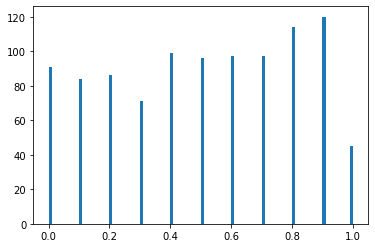

tf.Tensor(0.0010958149, shape=(), dtype=float32)
tf.Tensor(0.0010961356, shape=(), dtype=float32)
tf.Tensor(0.0010957164, shape=(), dtype=float32)
tf.Tensor(0.0010961179, shape=(), dtype=float32)
tf.Tensor(0.0010973088, shape=(), dtype=float32)
tf.Tensor(0.0010969139, shape=(), dtype=float32)
tf.Tensor(0.0010966304, shape=(), dtype=float32)
tf.Tensor(0.0011001158, shape=(), dtype=float32)
tf.Tensor(0.0010987376, shape=(), dtype=float32)
tf.Tensor(0.0010968837, shape=(), dtype=float32)


In [149]:
import tensorflow as tf
import numpy as np

# Define your constants
transaction_rate = 0.015
crra_coefficient = -1  # CRRA coefficient, adjust as needed

def newWealthWithTC(W, r, pi_pre, pi_new):
    W_new = tf.reduce_sum(W * pi_pre * (1 + r))
    W_new = W_new - W_new * transaction_rate * tf.norm(pi_new - pi_pre, ord=1)
    #print(W,r,pi_pre,pi_new,W_new)
    return W_new

# Define the custom loss function
def custom_loss(initial_wealth, initial_portfolio, upper_b, lower_b, returns):
    input_size = tf.shape(upper_b)[0]
    total_loss = 0.0

    for _ in range(input_size):
        wealth = [tf.constant([initial_wealth], dtype=tf.float32)]
        portfolio = [tf.constant(initial_portfolio, dtype=tf.float32)]

        #constraint_loss = 0.0
        for i in range(T):
            w = wealth[-1]
            pi = portfolio[-1]
            pi_new = tf.identity(pi)[:-1]

            # constraint_loss += tf.reduce_sum(tf.nn.relu(l_b - u_b)) * 1000.0

            # pi_new = tf.maximum(l_b, tf.minimum(u_b, pi_new))
            # risk_free_allocation = 1 - tf.reduce_sum(pi_new)

            closest_p_ind, __ = closest_probability_distn_TF(input_data[_, i])
            pi_star = tf.convert_to_tensor(optimal_pi_star[(closest_p_ind, i)],dtype = tf.float32)
            #pi_star_arrays.append(pi_star)
            #print(pi_star)
            pi_star = pi_star[:-1]
            u_b = upper_b[_, i]
            l_b = lower_b[_, i]
            u_b = tf.minimum(tf.ones(n, dtype=tf.float32), pi_star + u_b)
            l_b = tf.maximum(-tf.ones(n, dtype=tf.float32), pi_star - l_b)
            #print(l_b,u_b)
            # Your logic for updating u_b, l_b, and pi_new goes here
            pi_new = tf.maximum(l_b, tf.minimum(u_b, pi_new))
            risk_free_allocation = 1 - tf.reduce_sum(pi_new)
            pi_new = tf.concat([pi_new, [risk_free_allocation]], axis=0)
            #pi_new = tf.concat([pi_new, [risk_free_allocation]], axis=0)
            portfolio.append(pi_new)

            new_wealth = newWealthWithTC(w, returns[_][i], pi, pi_new)
            wealth.append(new_wealth)
        # print(wealth)
        # print(portfolio)
        loss = -((wealth[-1] ** crra_coefficient) / crra_coefficient) 
        #print(wealth)
        total_loss += loss

    return total_loss / tf.cast(input_size, dtype=tf.float32)

# Define the RNN cell with two neural networks
class CustomRNNCell(tf.keras.layers.Layer):
    # def __init__(self, input_size, output_size):
    #     super(CustomRNNCell, self).__init__()
    #     self.input_size = input_size
    #     self.output_size = output_size

    #     self.fc1 = tf.keras.Sequential([
    #         tf.keras.layers.Dense(80, activation='tan h'),
    #         tf.keras.layers.Dense(40, activation='tanh'),
    #         tf.keras.layers.Dense(20, activation='tanh'),
    #         tf.keras.layers.Dense(output_size, activation='tanh')
    #     ])

    # def call(self, x):
    #     out = self.fc1(x)
    #     lower_b = out
    #     upper_b = out
    #     return lower_b, upper_b
    def __init__(self, output_size):
        super(CustomRNNCell, self).__init__()
        #self.rnn = tf.keras.layers.SimpleRNN(output_size, return_sequences=True)
        self.fc1 = tf.keras.layers.Dense(n, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.fc2 = tf.keras.layers.Dense(n, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))

    def call(self, x):
        # out = self.rnn(x)
        # out_l, out_u = tf.split(self.fc(out), num_or_size_splits=2, axis=-1)
        out_l = self.fc1(x)
        out_u = self.fc2(x)
        return out_l, out_u

# # Generate some example data
# n_samples = 1
# input_data = []
# return_samples = []

# for i in range(n_samples):
#     sample = generate_monte_carlo_sample()  # You should implement this function
#     returns_for_this_sample = [sample[time][1] for time in range(T)]
#     return_samples.append(returns_for_this_sample)

#     initial_p = np.random.rand(N)
#     initial_p /= np.sum(initial_p)
#     input_to_rnn = [initial_p]

#     for time in range(T - 1):
#         p = input_to_rnn[-1]
#         p_new = updateBelief_for_RNN(sample[time][1], p)  # You should implement this function
#         input_to_rnn.append(p_new)

#     input_data.append(input_to_rnn)

# input_data = tf.constant(input_data, dtype=tf.float32)
# return_samples = tf.constant(return_samples, dtype=tf.float32)
n_samples = 200
input_data = []
return_samples= []
cnt0 = 0
plot_x = []
for i in range(n_samples):
    sample = generate_monte_carlo_sample()
    if(sample[0][0]==0):
        cnt0+=1
    returns_for_this_sample = []
    for time in range(T):
        returns_for_this_sample.append(sample[time][1])
    return_samples.append(returns_for_this_sample)
    #return_samples.append()
    initial_p = np.random.rand(N)
    initial_p/=np.sum(initial_p)
    initial_p = closest_probability_distn(initial_p)[1]
    plot_x.append(initial_p[0])
    input_to_rnn = [initial_p]
    for time in range(T-1):
        p = input_to_rnn[-1]
        p_new,__ = updateBelief(sample[time][1],p)
        p_new = closest_probability_distn(p_new)[1]
        plot_x.append(p_new[0])
        input_to_rnn.append(p_new)
    input_data.append(input_to_rnn)

print(cnt0)
print(len(plot_x))
import matplotlib.pyplot as plt
plt.hist(plot_x,bins = 100)
plt.show()

input_data = tf.constant(input_data, dtype=tf.float32)
return_samples = tf.constant(return_samples, dtype=tf.float32)
# Create the RNN cell and optimizer
input_size = N
output_size = n
rnn_cell_57 = CustomRNNCell(output_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

#Training loop
for iter in range(10):
    with tf.GradientTape() as tape:
        lb, ub = rnn_cell_57(input_data)
        initial_wealth = 1000
        initial_portfolio = np.random.rand(n + 1).astype(np.float32)
        initial_portfolio /= np.sum(initial_portfolio)
        loss = custom_loss(initial_wealth, initial_portfolio, ub, lb, return_samples)

    gradients = tape.gradient(loss, rnn_cell_57.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rnn_cell_57.trainable_variables))

    print(loss)


[0. 1.] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.02 0.98] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.04 0.96] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.06 0.94] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.08 0.92] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.1 0.9] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.12 0.88] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.14 0.86] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.16 0.84] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.18 0.82] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
[0.2 0.8] tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float

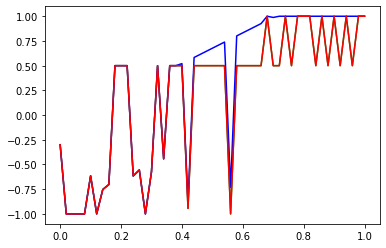

In [ ]:
import matplotlib.pyplot as plt
x_values = []
upper_b = []
lower_b = []
portfolio_values = []
for p in possible_probabities:
    p_normal = p[0]
    x_values.append(p_normal)
    pi_star = optimal_pi_star[(reverse_index[tuple(p)],2)]
    portfolio_values.append(pi_star[0])
    l_b,u_b = rnn_cell_57(tf.constant([[p]*T],dtype = tf.float32))
    print(p,l_b[0][1][0],u_b[0][1][0])
    lower_b.append(max(-1.0,(pi_star[0]-l_b[0][2][0])))
    upper_b.append(min(1.0,(pi_star[0]+u_b[0][2][0])))
plt.plot(x_values,lower_b,color= 'g')
plt.plot(x_values,upper_b,color = 'b')
plt.plot(x_values,portfolio_values,color = 'r')
plt.show()

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("No GPU detected. Using CPU.")

No GPU detected. Using CPU.


In [ ]:
#temp_input= tf.constant(temp_input,dtype = tf.float32)
for p in possible_probabities:
    print(p)
    temp_input = np.zeros((1,T,N))
    for j in range(T):
        temp_input[0][j] = tf.constant(p,dtype = tf.float32)
    temp_input= tf.constant(temp_input,dtype = tf.float32)
    lb, ub = rnn_cell(temp_input)
    lb = lb[0][0][0]
    ub = ub[0][0][0]
    print(lb,ub)

[0. 1.]


NameError: name 'rnn_cell' is not defined

In [ ]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,2][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.show()

print([optimal_pi_star[_,2] for _ in range(5)])

In [ ]:
lb,ub = rnn_cell(input_data)
print(lb[0])
print(ub[0])

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

transaction_rate = 0.1

def newWealth_withTC(W, r,pi_pre, pi_new):
    # print(pi_new)
    # print(pi_pre)
    W = np.multiply(pi_pre,1+r)
    diff = pi_pre-pi_new
    W_new = W - transaction_rate * tf.norm(diff, ord=1)
    return W_new

class CustomLoss(keras.losses.Loss):
    def __init__(self, crra_coefficient, **kwargs):
        super(CustomLoss, self).__init__(**kwargs)
        self.crra_coefficient = crra_coefficient

    def call(self, y_true, y_pred):
        initial_wealth, initial_portfolio = y_true
        lower_b, upper_b = y_pred
        wealth = [tf.convert_to_tensor(initial_wealth)]
        portfolio = [tf.convert_to_tensor(initial_portfolio)]

        for i in range(T):
            w = wealth[-1]
            pi = portfolio[-1]
            pi_new = tf.identity(pi)
            pi_new = pi_new[:-1]
            u_b = upper_b[0][i]
            l_b = lower_b[0][i]
            print(u_b)
            print(l_b)
            print(pi_new)
            pi_new = tf.maximum(l_b,tf.minimum(u_b,pi_new))


            risk_free_allocation = tf.constant(1.0) - tf.reduce_sum(pi_new)
            pi_new = tf.concat([pi_new, [risk_free_allocation]], axis=0)
            portfolio.append(pi_new)
            new_wealth = newWealth_withTC(w, pi, pi_new)
            wealth.append(new_wealth)

        final_wealth = wealth[-1]
        loss = -tf.pow(final_wealth, gamma) / gamma

        return loss

# Define your RNN cell as a custom Keras layer
class CustomRNNCell(keras.layers.Layer):
    def __init__(self, output_size, **kwargs):
        super(CustomRNNCell, self).__init__(**kwargs)
        self.output_size = output_size
        self.rnn = keras.layers.RNN(keras.layers.SimpleRNNCell(output_size), return_sequences=True, batch_size = 1)
        self.lower_bound_dense = keras.layers.Dense(n)
        self.upper_bound_dense = keras.layers.Dense(n)

    def call(self, x):
        out = self.rnn(x)
        lower_b = self.lower_bound_dense(out)
        upper_b = self.upper_bound_dense(out)
        return lower_b, upper_b

# Example usage of the custom loss function and RNN cell
N = 2
n = 1
T = 5
input_size = N  # Replace with the appropriate input size
output_size = 2 * n  # 2 output units, "no-trade" and "x-zone" decisions
crra_coefficient = -1  # CRRA coefficient, adjust as needed


rnn_cell = CustomRNNCell(output_size)
custom_loss = CustomLoss(crra_coefficient)

# Generate some example data
input_data = np.random.randn(1,T, N)  # (sequence_length, input_size)

optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Forward pass and compute loss
for iter in range(5):
    lb, ub = rnn_cell(input_data)
    print(lb, ub)
    
    initial_wealth = 1
    initial_portfolio = np.ones(n+1,dtype="float32") / (n + 1)
    
    loss = custom_loss([initial_wealth, initial_portfolio], [lb,ub])

    print(loss)
    
    grads = custom_loss.gradient([initial_wealth, initial_portfolio, ub, lb], [0])
    optimizer.apply_gradients(zip(grads, rnn_cell.trainable_variables))


In [ ]:
import torch
import torch.nn as nn

# Define the RNN parameters
input_size = 10  # Input feature size
hidden_size = 20  # Hidden state size
num_layers = 2  # Number of RNN layers
sequence_length = 5  # Length of the input sequence
batch_size = 3  # Number of sequences in a batch

# Create sample input data
input_data = torch.randn(batch_size, sequence_length, input_size)

# Define the RNN layer
rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

# Pass the input data through the RNN
output, hidden = rnn(input_data)

# 'output' contains the output at each time step
# 'hidden' contains the hidden state at the final time step

# Print the shapes of output and hidden
print("Output shape:", output.shape)
print("Hidden shape:", hidden.shape)


In [ ]:
import tensorflow as tf
import numpy as np

# Define the parameters, including the output size (2 * n)
n = 5  # You can change the value of n according to your problem
output_size = 2 * n

# Define the custom RNN cell
class CustomRNNCell(tf.keras.layers.Layer):
    def __init__(self, output_size):
        super(CustomRNNCell, self).__init__()
        self.rnn = tf.keras.layers.SimpleRNN(output_size, return_sequences=True)
        self.fc = tf.keras.layers.Dense(2 * n, activation='sigmoid')

    def call(self, x):
        out = self.rnn(x)
        out_l, out_u = tf.split(self.fc(out), num_or_size_splits=2, axis=-1)
        return out_l, out_u

# Create an instance of the custom RNN cell
rnn_cell = CustomRNNCell(output_size)

# Define some input sequences for testing
input_seq1 = tf.constant([[[0.2, 0.8], [0.5, 0.5], [0.7, 0.3]]], dtype=tf.float32)  # Example input 1
input_seq2 = tf.constant([[[0.6, 0.4], [0.4, 0.6], [0.1, 0.9]]], dtype=tf.float32)  # Example input 2
input_seq3 = tf.constant([[[0.3, 0.7], [0.2, 0.8], [0.9, 0.1]]], dtype=tf.float32)  # Example input 3

# Obtain initial outputs for the input sequences
initial_outputs1 = rnn_cell(input_seq1)
initial_outputs2 = rnn_cell(input_seq2)
initial_outputs3 = rnn_cell(input_seq3)

# Print the initial outputs
print("Initial Outputs for Input Sequence 1:")
print("Lower Bounds:")
print(initial_outputs1[0].numpy())
print("Upper Bounds:")
print(initial_outputs1[1].numpy())
print()

print("Initial Outputs for Input Sequence 2:")
print("Lower Bounds:")
print(initial_outputs2[0].numpy())
print("Upper Bounds:")
print(initial_outputs2[1].numpy())
print()

print("Initial Outputs for Input Sequence 3:")
print("Lower Bounds:")
print(initial_outputs3[0].numpy())
print("Upper Bounds:")
print(initial_outputs3[1].numpy())
